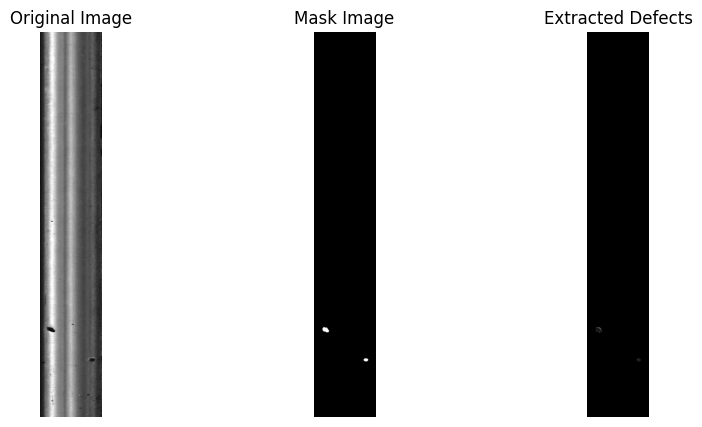

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
original = cv2.imread('iiseg-in2-a_0.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('iiseg-in2-a-gt_0.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure mask is binary
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Apply mask to extract defects
extracted_defects = cv2.bitwise_and(original, original, mask=binary_mask)

# Show results
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Mask Image")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Defects")
plt.imshow(extracted_defects, cmap='gray')
plt.axis('off')

plt.show()


In [17]:
from pathlib import Path
import cv2
import numpy as np
import os

# Set your actual folder path
main_directory = Path(r'C:\Users\ASUS\Documents\extraction\train_set')

original_folder = main_directory / 'type-b-images'
mask_folder = main_directory / 'type-b-groundtruth'
output_folder = main_directory / 'extracted_defects_train'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through all original images
for filename in os.listdir(original_folder):
    if filename.endswith('.jpg'):
        original_path = original_folder / filename

        # Construct mask name based on the convention
        # Replace '_<number>' with '-gt_<number>'
        number_part = filename.split('_')[-1]  # example: "0.jpg"
        mask_name = filename.replace('_' + number_part, f'-gt_{number_part}')
        mask_path = mask_folder / mask_name

        if mask_path.exists():
            original = cv2.imread(str(original_path), cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            extracted_defects = cv2.bitwise_and(original, original, mask=binary_mask)

            output_name = filename.replace('.jpg', '_defects.jpg')
            output_path = output_folder / output_name
            cv2.imwrite(str(output_path), extracted_defects)

            print(f"Saved: {output_name}")
        else:
            print(f"Mask not found for: {filename} — expected: {mask_name}")

print("Defect extraction completed!")


Saved: iiseg-in2-b_0_defects.jpg
Saved: iiseg-in2-b_1_defects.jpg
Saved: iiseg-in2-b_10_defects.jpg
Saved: iiseg-in2-b_100_defects.jpg
Saved: iiseg-in2-b_101_defects.jpg
Saved: iiseg-in2-b_102_defects.jpg
Saved: iiseg-in2-b_103_defects.jpg
Saved: iiseg-in2-b_104_defects.jpg
Saved: iiseg-in2-b_105_defects.jpg
Saved: iiseg-in2-b_106_defects.jpg
Saved: iiseg-in2-b_107_defects.jpg
Saved: iiseg-in2-b_108_defects.jpg
Saved: iiseg-in2-b_109_defects.jpg
Saved: iiseg-in2-b_11_defects.jpg
Saved: iiseg-in2-b_110_defects.jpg
Saved: iiseg-in2-b_111_defects.jpg
Saved: iiseg-in2-b_112_defects.jpg
Saved: iiseg-in2-b_113_defects.jpg
Saved: iiseg-in2-b_114_defects.jpg
Saved: iiseg-in2-b_115_defects.jpg
Saved: iiseg-in2-b_116_defects.jpg
Saved: iiseg-in2-b_117_defects.jpg
Saved: iiseg-in2-b_118_defects.jpg
Saved: iiseg-in2-b_119_defects.jpg
Saved: iiseg-in2-b_12_defects.jpg
Saved: iiseg-in2-b_120_defects.jpg
Saved: iiseg-in2-b_121_defects.jpg
Saved: iiseg-in2-b_122_defects.jpg
Saved: iiseg-in2-b_123_defe

In [18]:
import cv2
import os
import pandas as pd
from pathlib import Path

defects_folder = Path(r'C:\Users\ASUS\Documents\extraction\train_set\extracted_defects_train')
labels = []

for filename in os.listdir(defects_folder):
    if filename.endswith('.jpg'):
        img = cv2.imread(str(defects_folder / filename), cv2.IMREAD_GRAYSCALE)
        if cv2.countNonZero(img) > 0:
            label = 1  # Defect present
        else:
            label = 0  # No defect
        labels.append({'image': filename, 'label': label})

# Save to CSV
df = pd.DataFrame(labels)
df.to_csv(defects_folder / 'defect_labels.csv', index=False)
print("Label file created!")


Label file created!


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Simple CNN for defect detection
class DefectClassifier(nn.Module):
    def __init__(self):
        super(DefectClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 6 * 6, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate, compile, train...


In [24]:
from torch.utils.data import Dataset
import pandas as pd
import cv2
import torch

class DefectDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        label = self.labels_df.iloc[idx, 1]
        img_path = f"{self.img_dir}/{img_name}"

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))  # resizing for small CNN
        image = image / 255.0  # normalize to [0,1]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # add channel dimension

        label = torch.tensor(label, dtype=torch.float32)  # for binary output

        return image, label


In [28]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Paths
csv_file = r'C:\Users\ASUS\Documents\extraction\train_set\defect_labels.csv'
img_dir = r'C:\Users\ASUS\Documents\extraction\train_set\extracted_defects_train'

# Dataset and Dataloader
dataset = DefectDataset(csv_file, img_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Model, Loss, Optimizer
model = DefectClassifier()
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(10):
    total_loss = 0
    for images, labels in dataloader:
        labels = labels.unsqueeze(1)  # match output shape

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")


Epoch 1, Loss: 0.28804714319994673
Epoch 2, Loss: 0.0008185621480834016
Epoch 3, Loss: 2.629131113707217e-06
Epoch 4, Loss: 3.8091104670456843e-07
Epoch 5, Loss: 1.6763809007613872e-07
Epoch 6, Loss: 8.102507331742004e-08
Epoch 7, Loss: 3.9115553018831406e-08
Epoch 8, Loss: 2.7008358327584858e-08
Epoch 9, Loss: 1.6763808674546965e-08
Epoch 10, Loss: 0.0


In [29]:
torch.save(model.state_dict(), "defect_classifier.pth")
print("Model saved!")


Model saved!


In [30]:
from pathlib import Path
import cv2
import numpy as np
import os

# Set your actual folder path
main_directory = Path(r'C:\Users\ASUS\Documents\extraction\test_set')

original_folder = main_directory / 'type-a-images'
mask_folder = main_directory / 'type-a-groundtruth'
output_folder = main_directory / 'extracted_defects_test'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through all original images
for filename in os.listdir(original_folder):
    if filename.endswith('.jpg'):
        original_path = original_folder / filename

        # Construct mask name based on the convention
        # Replace '_<number>' with '-gt_<number>'
        number_part = filename.split('_')[-1]  # example: "0.jpg"
        mask_name = filename.replace('_' + number_part, f'-gt_{number_part}')
        mask_path = mask_folder / mask_name

        if mask_path.exists():
            original = cv2.imread(str(original_path), cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            extracted_defects = cv2.bitwise_and(original, original, mask=binary_mask)

            output_name = filename.replace('.jpg', '_defects.jpg')
            output_path = output_folder / output_name
            cv2.imwrite(str(output_path), extracted_defects)

            print(f"Saved: {output_name}")
        else:
            print(f"Mask not found for: {filename} — expected: {mask_name}")

print("Defect extraction completed!")


Saved: iiseg-in2-a_0_defects.jpg
Saved: iiseg-in2-a_1_defects.jpg
Saved: iiseg-in2-a_10_defects.jpg
Saved: iiseg-in2-a_11_defects.jpg
Saved: iiseg-in2-a_12_defects.jpg
Saved: iiseg-in2-a_13_defects.jpg
Saved: iiseg-in2-a_14_defects.jpg
Saved: iiseg-in2-a_15_defects.jpg
Saved: iiseg-in2-a_16_defects.jpg
Saved: iiseg-in2-a_17_defects.jpg
Saved: iiseg-in2-a_18_defects.jpg
Saved: iiseg-in2-a_19_defects.jpg
Saved: iiseg-in2-a_2_defects.jpg
Saved: iiseg-in2-a_20_defects.jpg
Saved: iiseg-in2-a_21_defects.jpg
Saved: iiseg-in2-a_22_defects.jpg
Saved: iiseg-in2-a_23_defects.jpg
Saved: iiseg-in2-a_24_defects.jpg
Saved: iiseg-in2-a_25_defects.jpg
Saved: iiseg-in2-a_26_defects.jpg
Saved: iiseg-in2-a_27_defects.jpg
Saved: iiseg-in2-a_28_defects.jpg
Saved: iiseg-in2-a_29_defects.jpg
Saved: iiseg-in2-a_3_defects.jpg
Saved: iiseg-in2-a_30_defects.jpg
Saved: iiseg-in2-a_31_defects.jpg
Saved: iiseg-in2-a_32_defects.jpg
Saved: iiseg-in2-a_33_defects.jpg
Saved: iiseg-in2-a_34_defects.jpg
Saved: iiseg-in2-a

In [31]:
from torch.utils.data import Dataset
import cv2
import os
import torch

class TestDefectDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_list = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        image = image / 255.0  # normalize
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # add channel dim

        return img_name, image


In [32]:
import torch

# Assuming you've defined DefectClassifier class already
model = DefectClassifier()
model.load_state_dict(torch.load('defect_classifier.pth'))
model.eval()

# Dataset and DataLoader
test_folder = r'C:\Users\ASUS\Documents\extraction\test_set\extracted_defects_test'
test_dataset = TestDefectDataset(test_folder)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prediction Loop
results = []

with torch.no_grad():
    for img_name, image in test_loader:
        output = model(image)
        prediction = (output.item() > 0.5)  # Binary: 1 if defect, 0 if no defect
        results.append({'image': img_name[0], 'prediction': int(prediction)})

# Save predictions to CSV
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('defect_predictions.csv', index=False)

print("Predictions saved to defect_predictions.csv")


Predictions saved to defect_predictions.csv


In [3]:
import cv2
import torch
import numpy as np
from torch import nn
import os

# === Model Definition ===
class DefectClassifier(nn.Module):
    def __init__(self):
        super(DefectClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 6 * 6, 64),  # ← for 24x24 input size!
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# === Extract Defect ===
def extract_defect(original_img_path, mask_img_path, save_path):
    original = cv2.imread(original_img_path)
    mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)

    if original is None or mask is None:
        print("❌ Error: Could not load one or both images!")
        return None

    mask = (mask > 0).astype(np.uint8) * 255
    defect_area = cv2.bitwise_and(original, original, mask=mask)
    cv2.imwrite(save_path, defect_area)
    return save_path

# === Predict Defect ===
def predict_defect(image_path, model_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (24, 24))  # <-- Corrected size
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    model = DefectClassifier()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        output = model(image)
        prediction = int(output.item() > 0.5)
    return prediction


# === Main Flow ===
if __name__ == '__main__':
    original_img = input("Enter path of Original Image: ")
    mask_img = input("Enter path of Mask Image: ")
    save_folder = input("Enter folder to save extracted defect: ")
    model_path = r'C:\Users\ASUS\Documents\extraction\defect_classifier.pth'

    filename = os.path.basename(original_img).split('.')[0] + '_defect_extracted.jpg'
    extracted_path = os.path.join(save_folder, filename)

    saved_image = extract_defect(original_img, mask_img, extracted_path)

    if saved_image:
        prediction = predict_defect(saved_image, model_path)
        if prediction == 1:
            print("✅ Defect Detected in Image!")
        else:
            print("🟢 No Defect Detected in Image.")


✅ Defect Detected in Image!
